# Analysis using raw functions (not the MNE package)


## imports

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functional import seq
from scipy import signal
from itertools import combinations 

%matplotlib inline

## helper functions

In [50]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.
    Source: https://raphaelvallat.com/bandpower.html

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper
    

    band = np.asarray(band)
    low, high = band
    
    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        if data.shape[0] < nperseg:
            return np.NaN
            
        
        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
        
    return bp

In [73]:
def index_to_time(x, time_index, step_size=1):
    if (x < 0 or x * step_size >= len(time_index)):
        return ''
    
    seconds = time_index[int(x*step_size)].total_seconds()
    return f"{int(seconds/60)}\' {seconds/60:.2f}\""

In [18]:
def get_config_value(config, *args):
    return reduce(lambda cfg, val: cfg[val], args, config)

# main stuff

In [36]:
cfg = {
    'paths': {
        'base': '../../data/AlphaTheta',
        'subjects': {
            'sam': {
                'prefix': '/sam-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-144100',
                        '20200304-144601'
                    ],
                    'meditation': [
                         '20200304-144933'   
                    ]
                }
            }
        }
    },
    'sampling_frequency': 300,
    'bands': {
        'gamma': [40, 100],
        'beta':  [12, 40],
        'alpha': [8, 12],
        'theta': [4, 8],
        'delta': [0.5, 4]
    }
}

In [172]:
subject_paths = get_config_value(cfg, 'paths', 'subjects', 'sam')

baseline = pd.read_pickle(f"{cfg['paths']['base']}/{subject_paths['prefix']}/offline/{get_config_value(subject_paths, 'recordings', 'baseline')[0]}-raw.pcl")
meditation =  pd.read_pickle(f"{cfg['paths']['base']}/{subject_paths['prefix']}/offline/{get_config_value(subject_paths, 'recordings', 'meditation')[0]}-raw.pcl")

In [173]:
def load_signal_data(data_type, subject='sam', number=0):
    subject_paths = get_config_value(cfg, 'paths', 'subjects', subject)
    data = pd.read_pickle(f"{cfg['paths']['base']}/{subject_paths['prefix']}/offline/{get_config_value(subject_paths, 'recordings', data_type)[0]}-raw.pcl")
    
    _t = data['timestamps'].reshape(-1)
    _t -= _t[0]

    return pd.DataFrame(data=data['signals'],
                              index=pd.TimedeltaIndex(_t, unit='s'), 
                              columns=data['ch_names'])

In [174]:
meditation_pd = load_signal_data('meditation')

In [24]:
# adjusting the timestmaps, I prefer relative values
_t = baseline['timestamps'].reshape(-1)
_t -= _t[0]

signals_pd = pd.DataFrame(data=baseline['signals'],
                          index=pd.TimedeltaIndex(_t, unit='s'), 
                          columns=baseline['ch_names'])

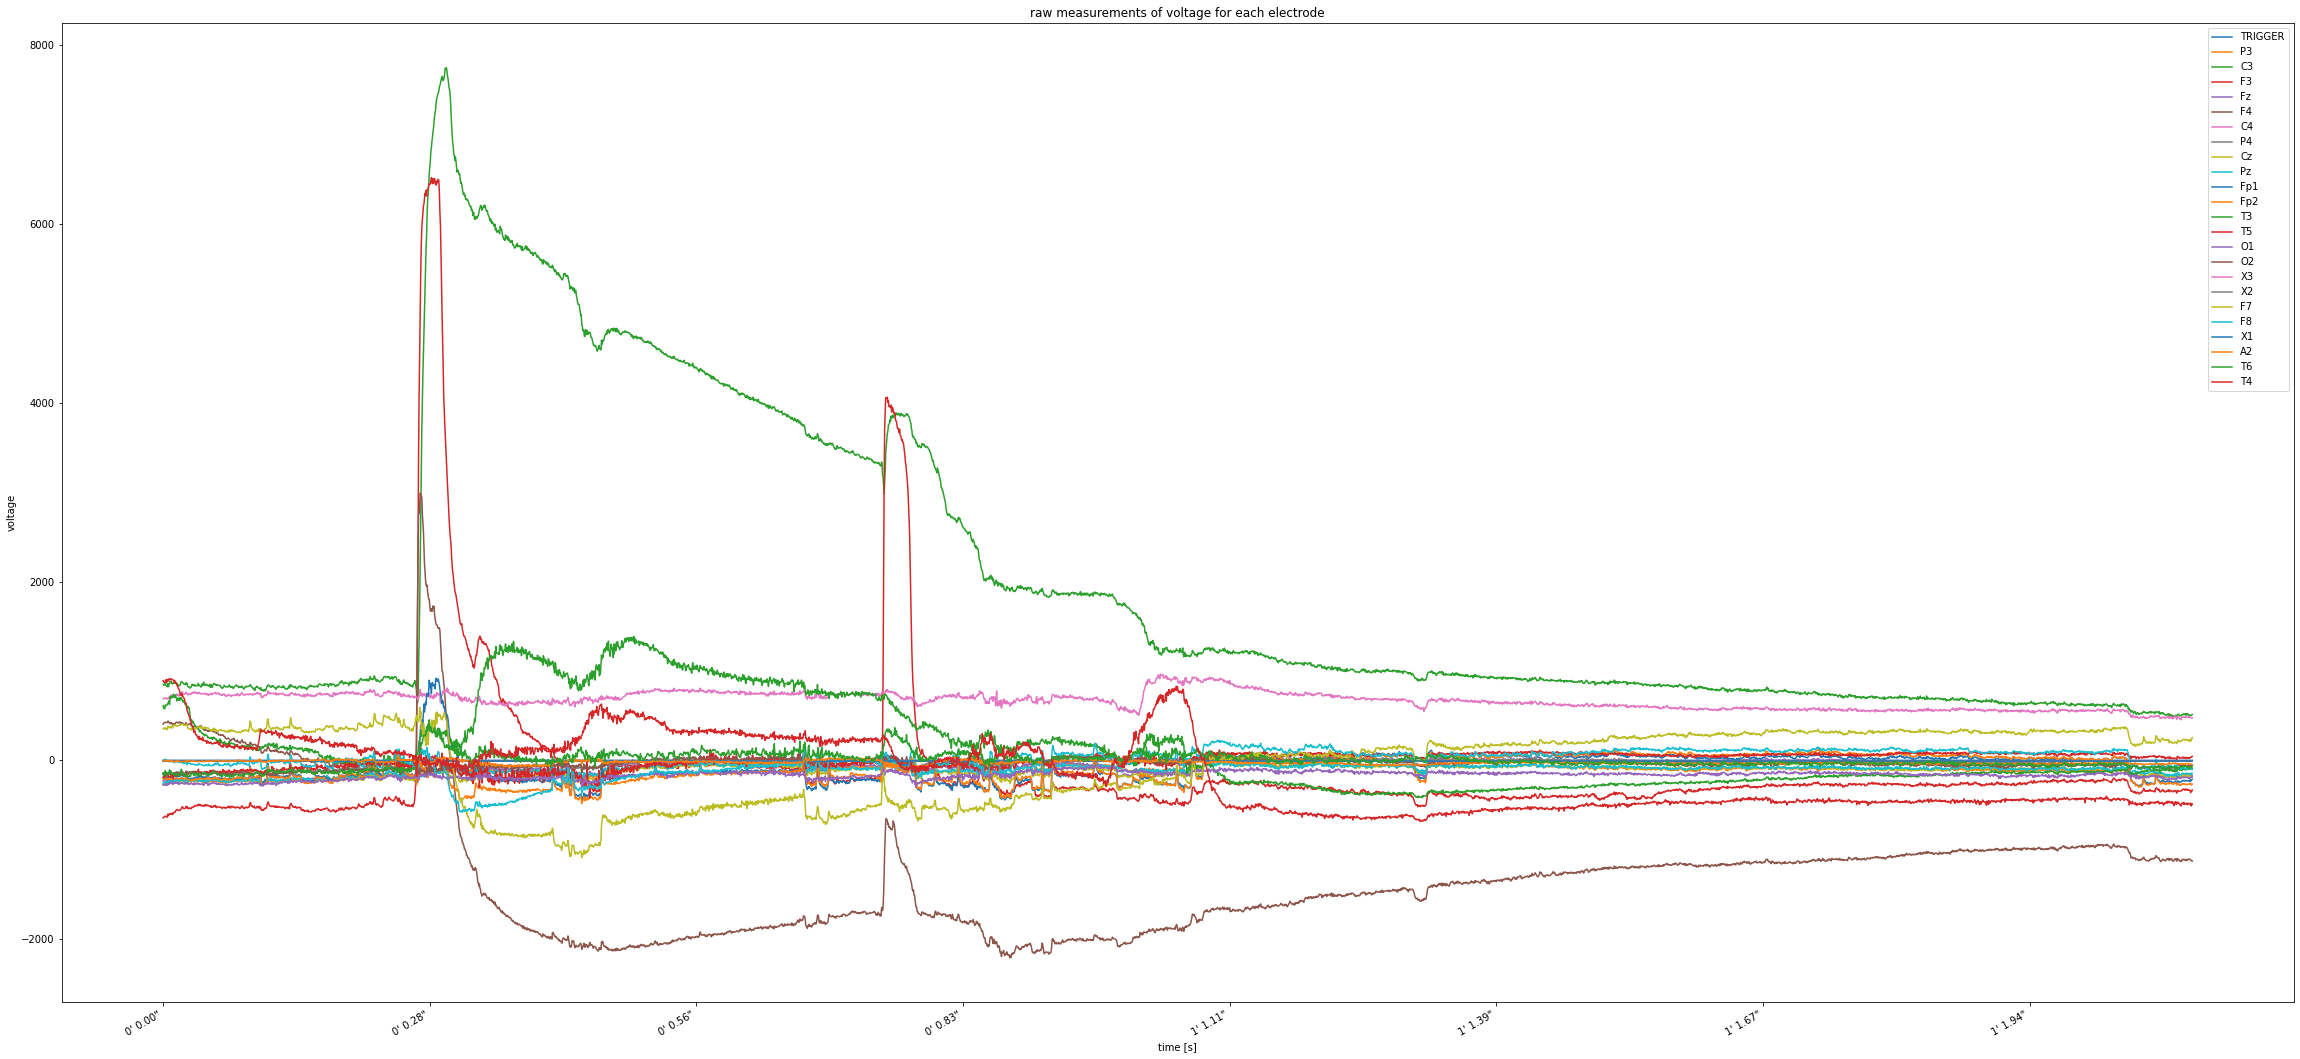

In [25]:
_sampling_rate=10
fig = signals_pd.loc[::_sampling_rate, :].plot(figsize=(40, 20), use_index=True)


fig.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: index_to_time(x, signals_pd.index, _sampling_rate)))
fig.set_xlabel('time [s]')
fig.set_ylabel('voltage')
fig.set_title('raw measurements of voltage for each electrode');

In [198]:
signals_pd.columns

Index(['TRIGGER', 'P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Pz', 'Fp1',
       'Fp2', 'T3', 'T5', 'O1', 'O2', 'X3', 'X2', 'F7', 'F8', 'X1', 'A2', 'T6',
       'T4'],
      dtype='object')

In [32]:
signals_pd.shape

(38052, 24)

In [177]:
def get_bandpower_for_electrode(signal_data, electrode='T5'):
    time_index_of_interest = signal_data.index

    bandpowers = {}

    for band_name, band_range in cfg['bands'].items():
        bandpowers[band_name] = signal_data.loc[time_index_of_interest, electrode_placement]\
            .rolling('1s')\
            .apply(lambda xs: bandpower(xs, cfg['sampling_frequency'], band_range))

    for bn_l, bn_r in combinations(cfg['bands'].keys(), 2):
        bandpowers[f"{bn_l} / {bn_r}"] = bandpowers[bn_l] / bandpowers[bn_r]
        
    return bandpowers, time_index_of_interest

In [179]:
def plot_bandpowers(bandpowers, time_index_of_interest):
    fig, axs = plt.subplots(nrows=len(bandpowers), sharex=True, figsize=(25, 15))
    time_index_as_seconds = [t.total_seconds() for t in time_index_of_interest]

    for i, (bn, bp) in enumerate(bandpowers.items()):
        axs[i].plot(bp.reset_index(drop=True))
        axs[i].set_ylabel(bn)

    axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: index_to_time(x, time_index_of_interest)))
    fig.suptitle(f"Bandpower of {electrode_placement}")
    
    return fig

In [178]:
meditation_bandpower, meditation_time_index = get_bandpower_for_electrode(meditation_pd)

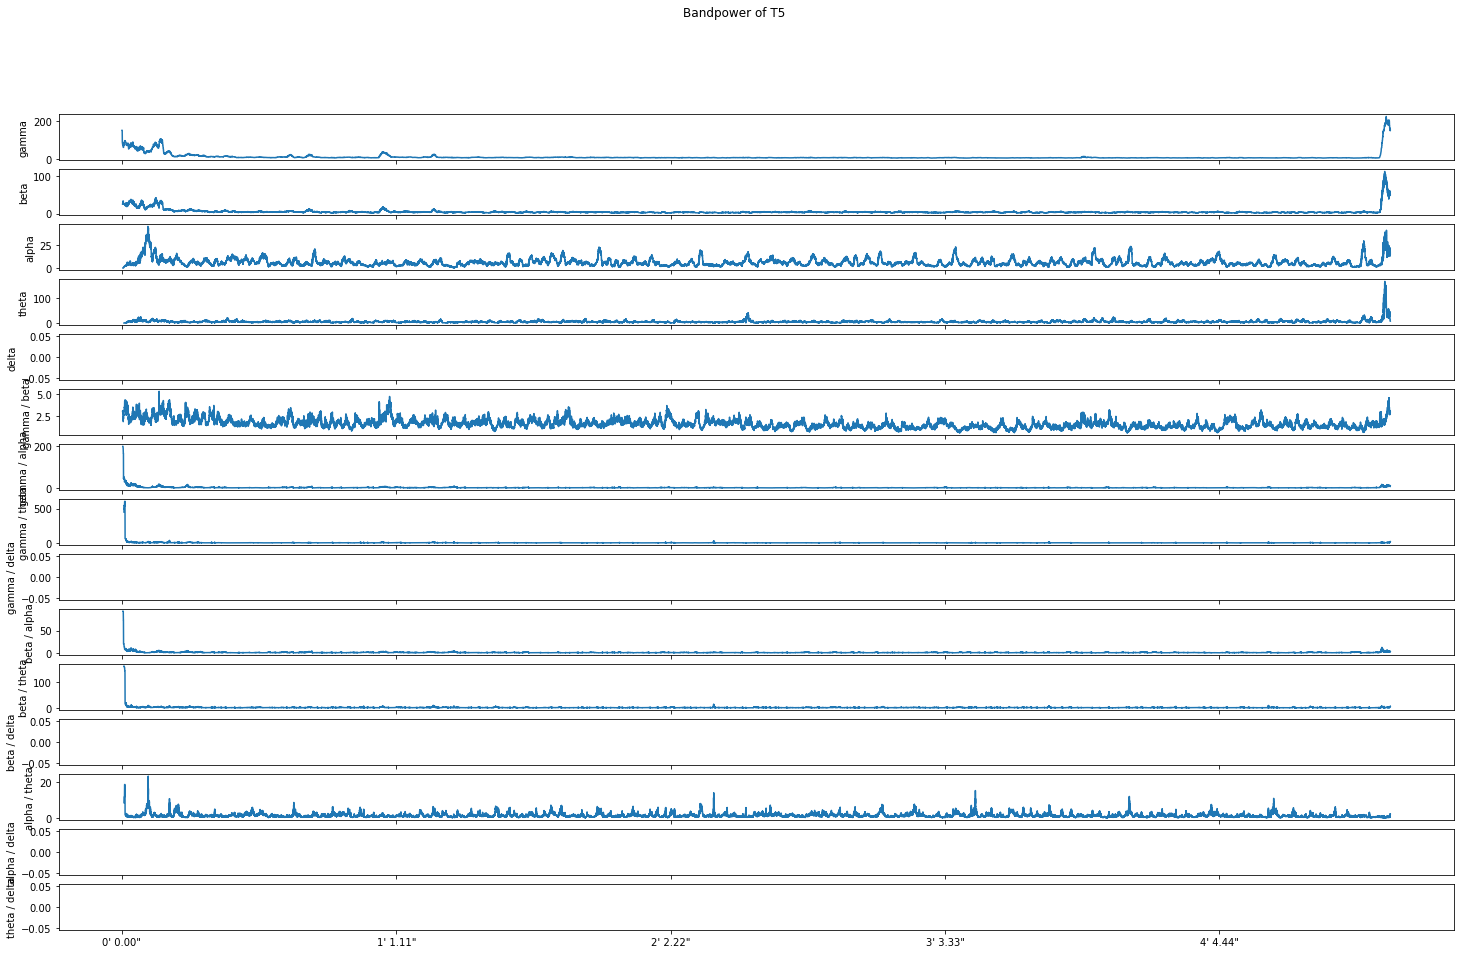

In [180]:
plot_bandpowers_bandpowers(meditation_bandpower, meditation_time_index);

In [165]:
# TODO what type of window? this is just a window with equal weight
# the thing with the index
electrode_placement = 'T5'

#time_index_of_interest = signals_pd.index[:5 * cfg['sampling_frequency']]
time_index_of_interest = signals_pd.index

bandpowers = {}
    
for band_name, band_range in cfg['bands'].items():
    bandpowers[band_name] = signals_pd.loc[time_index_of_interest, electrode_placement]\
        .rolling('1s')\
        .apply(lambda xs: bandpower(xs, cfg['sampling_frequency'], band_range))
    
for bn_l, bn_r in combinations(cfg['bands'].keys(), 2):
    bandpowers[f"{bn_l} / {bn_r}"] = bandpowers[bn_l] / bandpowers[bn_r]

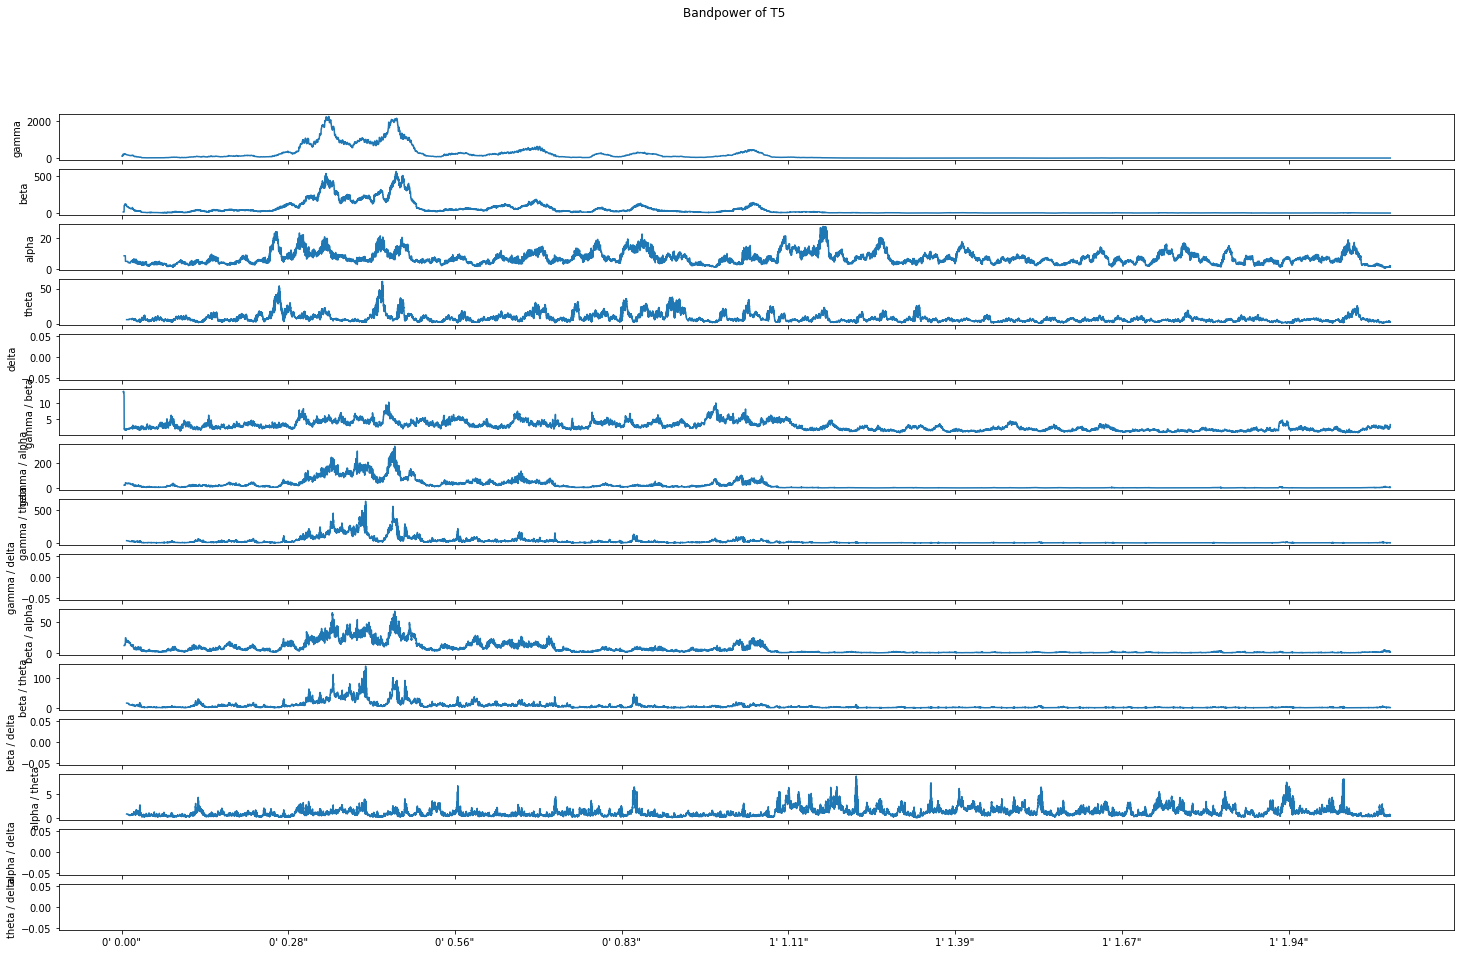

In [171]:
fig, axs = plt.subplots(nrows=len(bandpowers), sharex=True, figsize=(25, 15))
time_index_as_seconds = [t.total_seconds() for t in time_index_of_interest]

for i, (bn, bp) in enumerate(bandpowers.items()):
    axs[i].plot(bp.reset_index(drop=True))
    axs[i].set_ylabel(bn)
    
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: index_to_time(x, time_index_of_interest)))
fig.suptitle(f"Bandpower of {electrode_placement}");

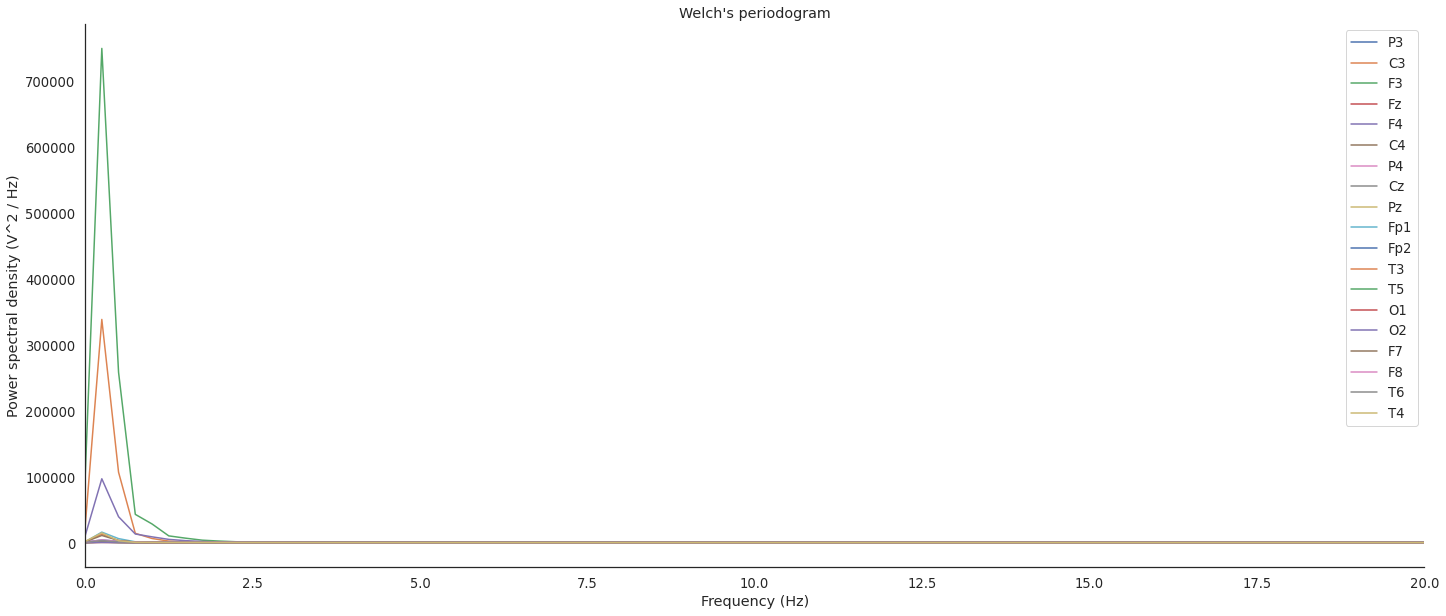

In [208]:
sampling_rate = 300
window_size = 4 * sampling_rate # in seconds

plt.figure(figsize=(24, 10))
for c in [c for c in signals_pd.columns if c not in ['TRIGGER', 'X1', 'X2', 'X3', 'A2']]:
    freqs, psd = signal.welch(signals_pd.loc[:, c], sampling_rate, nperseg=window_size)

    plt.plot(freqs, psd, label=c)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    #plt.ylim([0, psd.max() * 1.1])
    plt.title("Welch's periodogram")
    #plt.xlim([0, freqs.max()])
    plt.xlim([0, 20])
    sns.despine()
    
plt.legend();

In [213]:
# for a window size of... compute the power and compare it over time



bandpower(signals_pd.loc[:, 'T5'], 300., cfg['bands']['theta'])

7.676781094175913

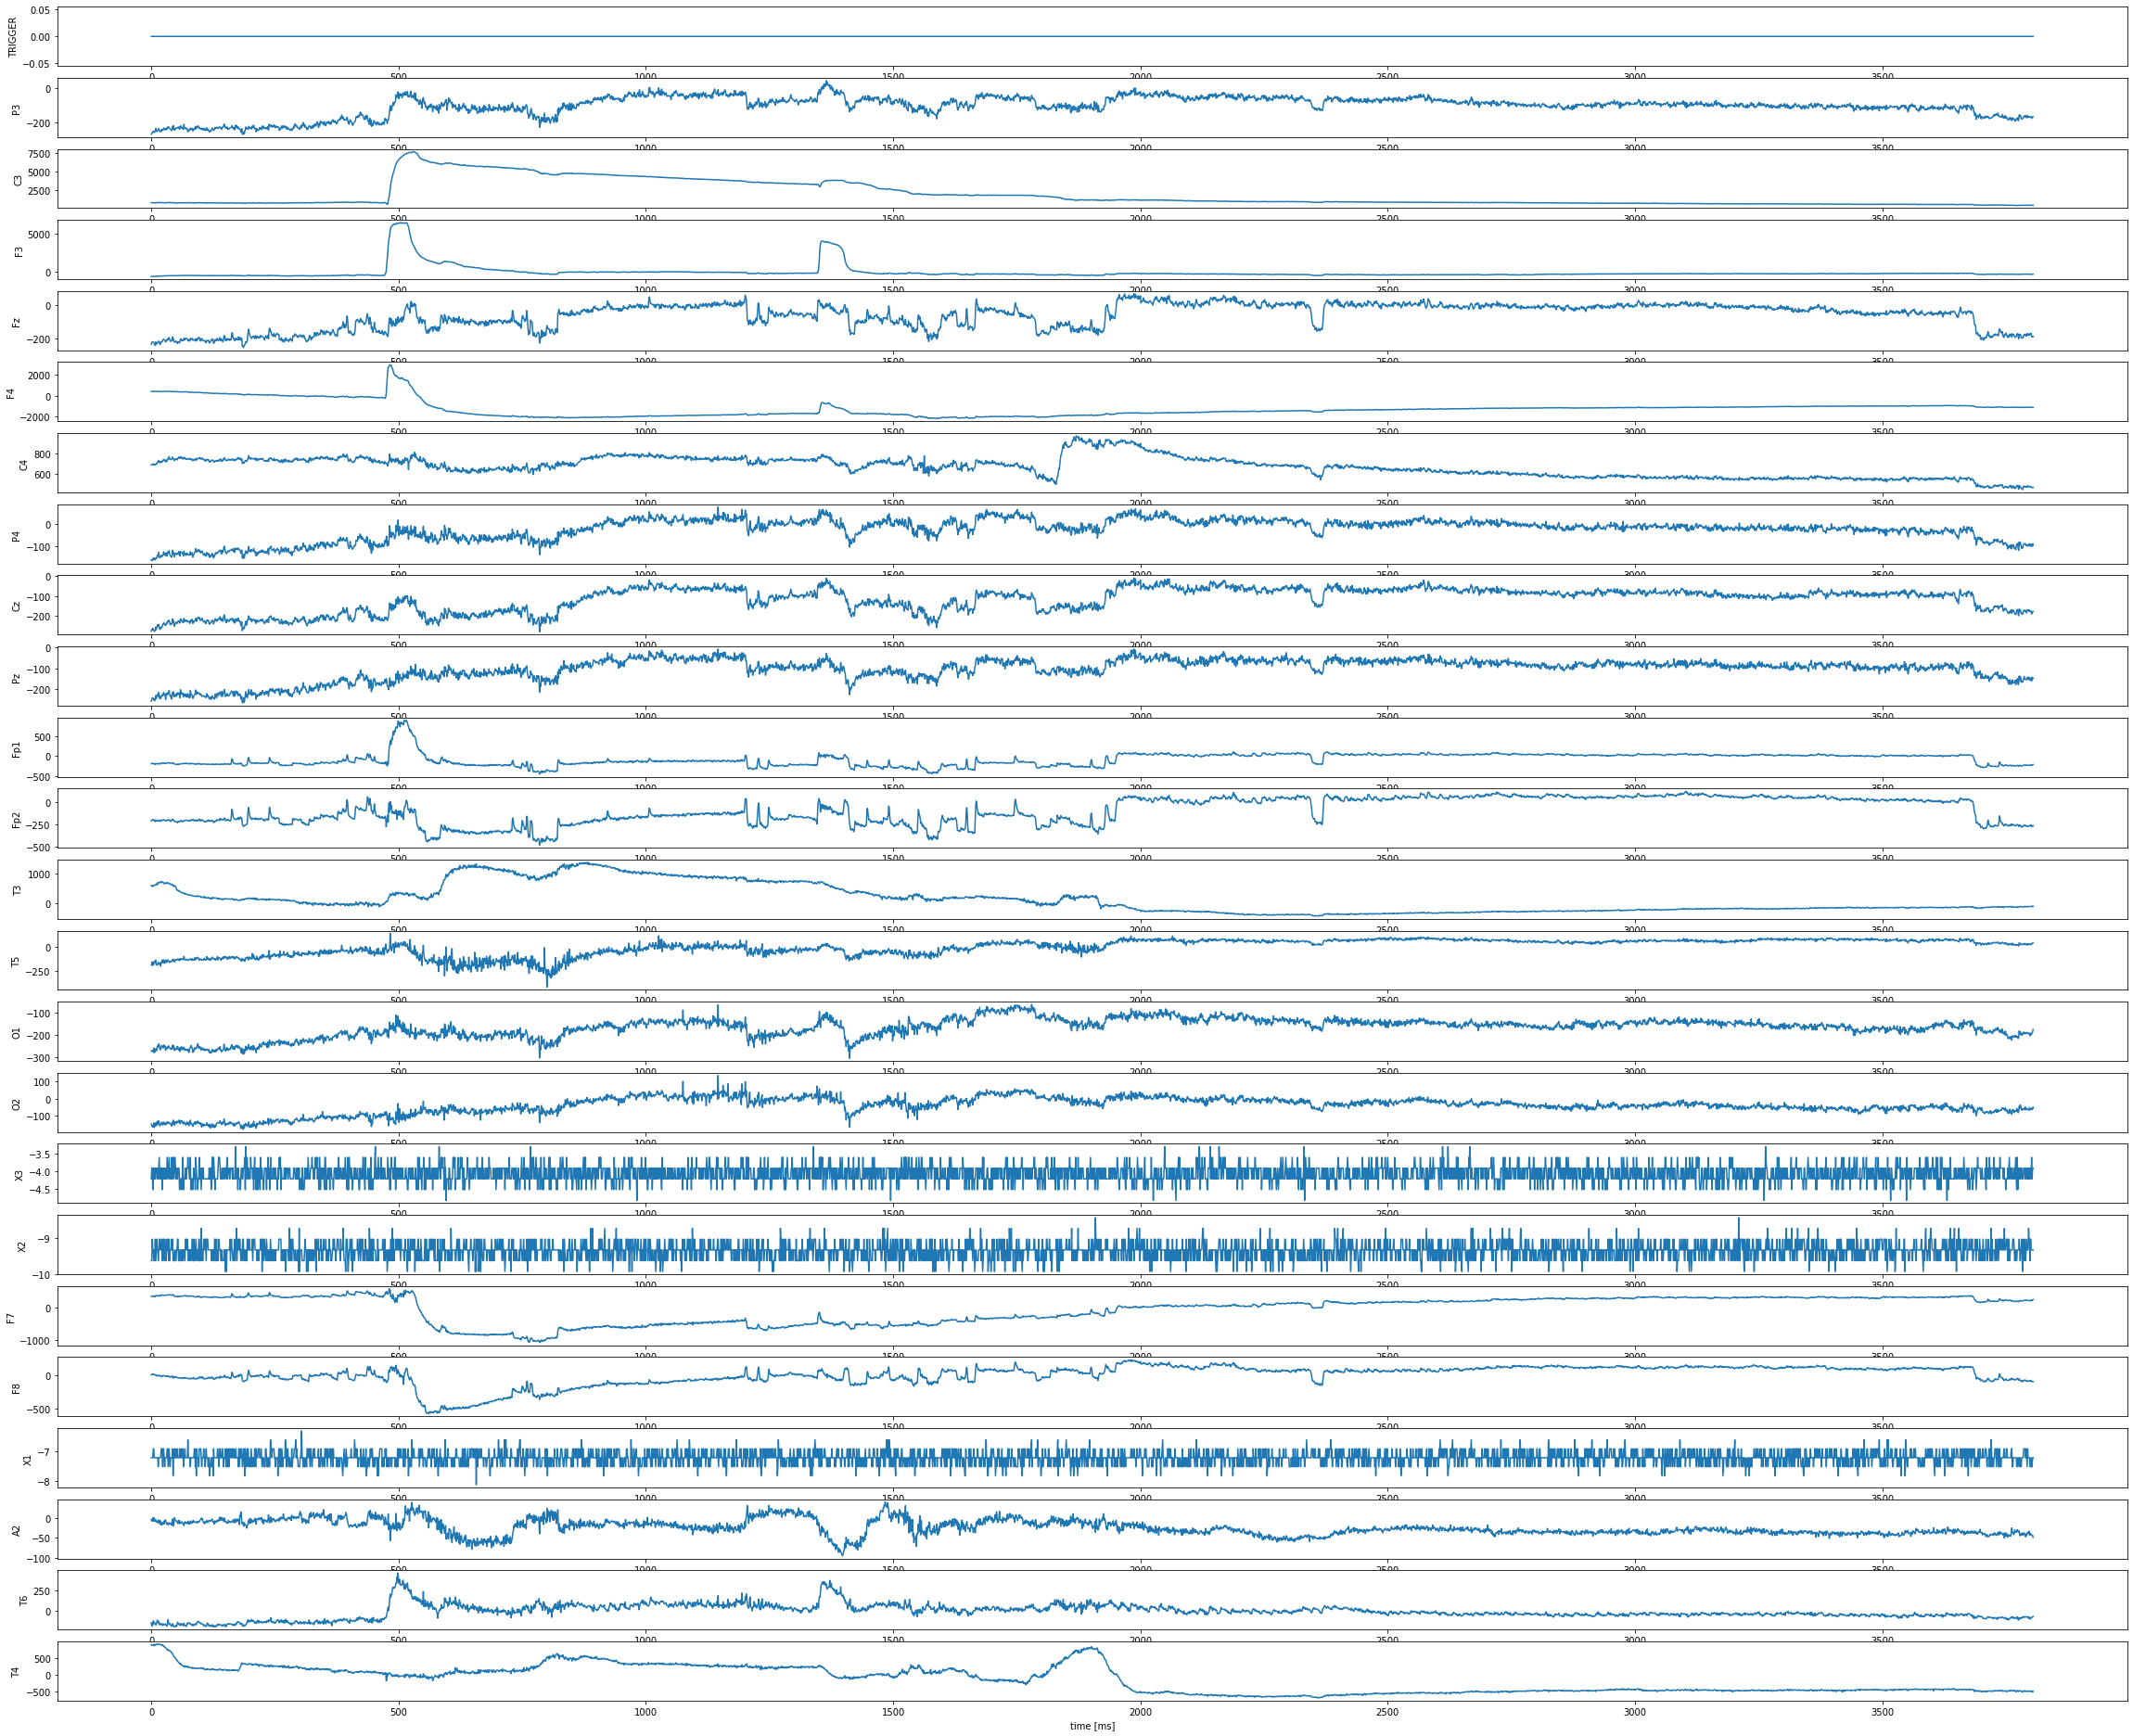

In [36]:
signals = baseline['signals']
fig, axs = plt.subplots(nrows=signals.shape[1], figsize=(40, 1.4 * signals.shape[1]))
for channel in range(signals.shape[1]):
    sns.lineplot(data=signals[::10, channel], ax=axs[channel], )
    axs[channel].set_ylabel(baseline['ch_names'][channel])
    
axs[-1].set_xlabel('time [ms]');

In [31]:
38052/60

634.2